In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy

In [3]:
from guide.dataset import GuideDataset

# Guide RNA Clustering Homework

First let's import the dataset. I'm using wrapper classes to represent the data so we can interact with it in an object-oriented fashion.

In [4]:
guide_dataset = GuideDataset('data/example_guide_data_annotated.tsv')
points = [p for p in guide_dataset.each_point()]
points = list(filter(lambda p: p.rna_folding_free_energy() < 900, points))

In [5]:
gene_names = [p.row['gene_name'] for p in points]
print(len(gene_names))
print(len(set(gene_names)))

63815
17419


## Inputs and Outputs

For this problem, the inputs are the spacer sequences, and the outputs (what we would like to predict from the inputs) are their activities -- essentially their effect on the population of cells. 

First let's try to look for some clusters in the activity outputs. We have data for the normalized count of cells still containing the spacer sequences after 0, 7, and 14 days, with and without the drug PLX. If CRISPR knocks out a gene essential for the cell's survival, we expect a spacer's activity (which I've negated here for intuitiveness) to be negative. In the presence of PLX, if CRISPR knocks out a gene that was preventing the cell from resisting PLX, we expect the activity below to be positive.

In [6]:
def plt_activity_histogram(key, color=None):
    plt.hist(numpy.array([getattr(p, key)() for p in points]), 50, range=(-10, 10), color=color, label=key, log=True)

In [7]:
def compare_activities(da, db):
    plt_activity_histogram('d{}_d{}_base_activity'.format(da, db))
    plt_activity_histogram('d{}_d{}_plx_activity'.format(da, db), color=(1, 1, 0.5, 0.5))
    plt.legend()
    plt.axvline(color='red')
    plt.title('D{} vs D{}'.format(da, db))
    plt.show()

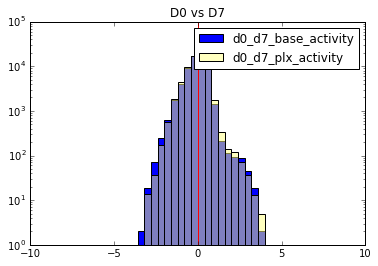

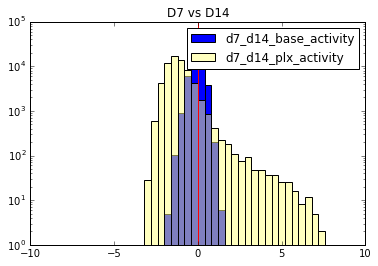

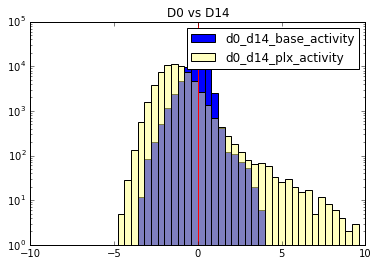

In [8]:
compare_activities(0, 7)
compare_activities(7, 14)
compare_activities(0, 14)

As we might expect, the PLX results show a bias towards the positive for certain sequences (meaning they successfully knocked out genes to give the cell resistance), and towards the negative for others (since PLX is toxic, any spacer sequence that wasn't effective should be suppressed). However, I was expecting to see more of a discrete segmentation between sequences that worked (gave the cell resistance) and sequences that didn't. Graph-wise, I was expecting two peaks, one slightly below 0 and one somewhere up higher. Here, though, we have a more-or-less exponential decay, making it harder to interpret the effect of the spacers as a boolean did-it-work-or-not outcome.

Also interesting is the fact that the PLX-induced die-offs only seemed to happen between D7 and D14; the D0 to D7 results with and without PLX look identical. Perhaps PLX is very slow-acting, or maybe the experimenters waited until D7 to add it?

The base, non-PLX results are a bit harder to interpret. The histogram seems pretty centered around 0, meaning that the spacers could either increase or decrease cells' survival rates. My first instinct was to interpret this as just experimental noise; but the shape of the histogram isn't perfectly symmetrical, and the histogram gets thinner between D7 and D14 (indicating some kind of equilibrium is reached), and the asymmetrical shape between D0 and D7 is replicated almost perfectly by the PLX results. So something is going on.

In [21]:
melting_temps = [point.rna_folding_melt_temp() for point in points]
free_energies = [point.rna_folding_free_energy() for point in points]
plx_activities = [point.d0_d14_plx_activity() for point in points]
base_activities = [point.d0_d14_base_activity() for point in points]
hairpin_stems = [point.hairpin().stem_length() for point in points]
hairpin_loops = [point.hairpin().loop_length() for point in points]
hairpin_starts = [point.hairpin().start_index() for point in points]

In [13]:
from matplotlib.colors import LogNorm

def activity_2dhist(x, y):
    plt.hist2d(eval(x), eval(y), bins=40, norm=LogNorm())
    plt.title('{} vs {}'.format(x, y))
    plt.xlim(-10,10)
    if y == 'free_energies':
        plt.ylim(-15,15)
    elif y == 'melting_temps':
        plt.ylim(-150,150)
    plt.axvline(color='black')
    plt.axhline(color='black')
    plt.colorbar()

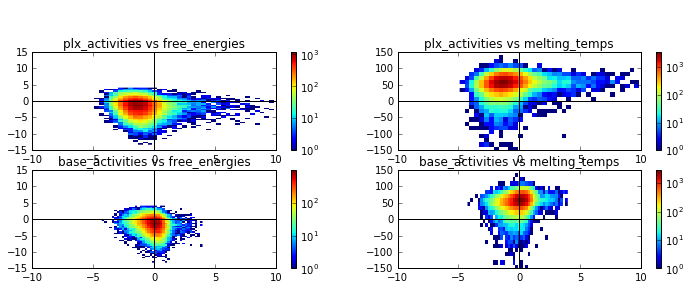

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(3,2,1)
activity_2dhist('plx_activities', 'free_energies')
plt.subplot(3,2,2)
activity_2dhist('plx_activities', 'melting_temps')
plt.subplot(3,2,3)
activity_2dhist('base_activities', 'free_energies')
plt.subplot(3,2,4)
activity_2dhist('base_activities', 'melting_temps')
plt.show()

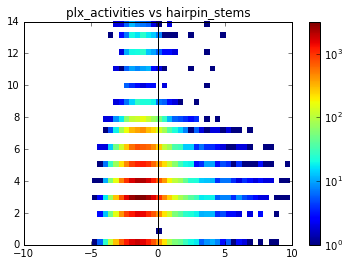

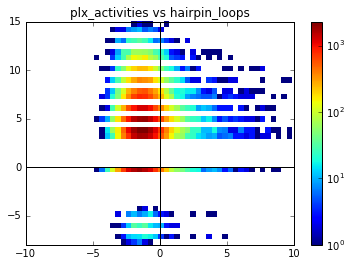

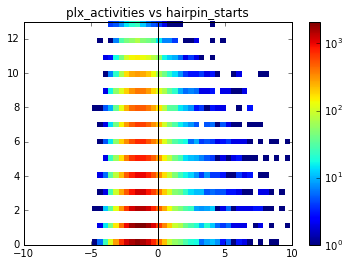

In [22]:
activity_2dhist('plx_activities', 'hairpin_stems')
plt.show()
activity_2dhist('plx_activities', 'hairpin_loops')
plt.show()
activity_2dhist('plx_activities', 'hairpin_starts')
plt.show()

In [26]:
neg_loops = list(filter(lambda p: p.hairpin().loop_length() < 0, points))

In [34]:
i = 1
print(neg_loops[i].rna_sequence())
neg_loops[i].row

CACCGGAGGGGCGCUGUAGC


{'folding_enthalpy': '-44.6',
 'folding_entropy': '-139.3',
 'folding_free_energy': '-1.4',
 'folding_hairpin': '[[3, 9, 1], [4, 8, 1], [11, 20, 1], [12, 19, 1]]',
 'folding_melt_temp': '47.1',
 'gene_name': 'AC011498.1',
 'norm_count_D14_Rep1': '2.680210193',
 'norm_count_D14_Rep2': '1.666069424',
 'norm_count_D7_Rep1': '2.079115175',
 'norm_count_D7_Rep2': '1.705924578',
 'norm_count_PLX14_Rep1': '1.234698384',
 'norm_count_PLX14_Rep2': '1.605643752',
 'norm_count_PLX7_Rep1': '3.366918569',
 'norm_count_PLX7_Rep2': '2.562287405',
 'norm_count_plasmid': '2.441041066',
 'spacer_id': 's_435',
 'spacer_seq': 'CACCGGAGGGGCGCTGTAGC'}